# Performance optimization for an online Random Forest
Group 4 - Case Study in Econometrics and Data Science

Sarah Dick - 2637856 \
Anne-Britt Analbers - 2662375 \
Amrohie Ramsaran - 2763388 \
Travis van Cornewal - 2731231 

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score

C:\Users\tcornew\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load the dataset
data = pd.read_csv("kc_house_data.csv").drop(["id", "date"], axis=1)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
X = data.drop(columns=["price"])
y = data["price"]

# Split into train(+validation) and test
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Then, split the train+validation set into separate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.2, random_state=0)

print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (12103, 18) (12103,)
Validation set shape: (3026, 18) (3026,)
Test set shape: (6484, 18) (6484,)


## Hyperparameter tuning

Here we are optimizing the hyperparameters using the train and validation sets. First, we train a baseline model and then use RandomizedSearchCV to find the best hyperparameters. Next, we evaluate the performance on the validation set.

**NOTE:** This process will take quite some time. Therefore, the best hyperparameters are also given below, in order for you to skip this step.

Best Hyperparameters: \
{ \
'n_estimators': 100, \
'min_samples_split': 2, \
'min_samples_leaf': 1, \
'max_features': 'auto', \
'max_depth': None, \
'bootstrap': True \
}

In [4]:
best_params = {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}

In [5]:
# rf = RandomForestRegressor(random_state=0)

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],   # Number of trees
#     'max_depth': [None, 10, 20, 30],  # Maximum depth of trees
#     'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
#     'min_samples_leaf': [1, 2, 4],    # Minimum samples per leaf
#     'max_features': ['auto', 'sqrt'], # Number of features to consider per split
#     'bootstrap': [True, False]        # Whether bootstrap samples are used
# }

# # Use RandomizedSearchCV to find the best hyperparameters
# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_grid,
#     n_iter=50,  # Number of different combinations to try
#     cv=3,  # 3-fold cross-validation
#     scoring='neg_mean_absolute_error',  # Evaluation metric
#     n_jobs=-1,  # Use all processors
#     verbose=2,
#     random_state=0
# )

# # Perform the search on the training data
# random_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = random_search.best_params_
# print("Best hyperparameters:", best_params)

# # Train a final model with the best hyperparameters
# best_rf = RandomForestRegressor(**best_params, random_state=0)
# best_rf.fit(X_train, y_train)

# # Evaluate on the validation set
# y_val_pred = best_rf.predict(X_val)
# error = mean_absolute_error(y_val, y_val_pred)

# print("Mean Absolute Error on validation set:", error)

## Experiment: Runtime and Accuracy 

After tuning the hyperparameters, we are running an experiment where we are comparing the performance of an online vs offline Random Forest when adding new features to the data. 

In an offline Random Forest, the entire model must be retrained whenever new features are added to the data. In comparison, an online Random Forest allows us to update the Random Forest by only re-training a subset of trees. Therefore, we define performance as a trade-off between Runtime and Accuracy.

Our objective is to determine whether an online Random Forest can dynamically add new features while obtaining similar accuracy levels comparable to an offline Random Forest but with significantly lower runtime, since we do not need for full retraining.

To simulate this we first take a subset of the training data, leaving out some of the features. Next, we will train a baseline model for both the offline and online Random Forest. Finally, we will retrain the offline Random Forest and update the online Random Forest with the complete set of features. Both the runtime and accuracy will be measured throughout this process. Below is a brief step-wise overview of the experiment:

Data
- Create a subset of the dataset, leaving out some of the features

Offline Random Forest
- Step 1: Train a model on the subset and evaluate performance
- Step 2: Train a new model using the complete set of features and evaluate performance

Online Random Forest
- Step 1: Train a baseline model on the subset and evaluate performance
- Step 2: Update the baseline model using the complete set of features and evaluate performance

Finally, compare runtime and accuracy between the offline and online Random Forest.

## Creating subsets of the data

Let's create a subset of the training data, leaving out some of the features. 

In [6]:
# Define the subset of features
subset_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition']

# Create a subset 
X_train_subset = X_train[subset_features]
X_test_subset = X_test[subset_features]

In [7]:
print("Train subset shape:", X_train_subset.shape)
X_train_subset.head()

Train subset shape: (12103, 8)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition
19552,4,1.75,1920,9500,1.0,0,0,4
3434,3,1.75,1460,9998,1.0,0,0,3
17400,3,1.75,2910,35200,1.5,0,0,3
10173,4,2.25,2770,13500,2.0,0,0,3
1138,2,2.00,1310,2550,2.0,0,0,3


In [8]:
print("Test subset shape:", X_test_subset.shape)
X_test_subset.head()

Test subset shape: (6484, 8)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition
17384,2,1.50,1430,1650,3.0,0,0,3
722,4,3.25,4670,51836,2.0,0,0,4
2680,2,0.75,1440,3700,1.0,0,0,3
18754,2,1.00,1130,2640,1.0,0,0,4
14554,4,2.50,3180,9603,2.0,0,2,3


## Offline Random Forest

Using our best hyperparameters and subset, we start by training our baseline model for the offline Random Forest.

In [9]:
# Initialize the Random Forest Regressor with the best hyperparameters
rf_model = RandomForestRegressor(**best_params, random_state=0)

# Start timing 
start_time = time.time()

# Train 
rf_model.fit(X_train_subset, y_train)

# Calculate runtime
runtime = time.time() - start_time

# Test
predictions = rf_model.predict(X_test_subset)

# Evaluate model performance 
mae = mean_absolute_error(y_test, predictions)
accuracy = r2_score(y_test, predictions)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Model Accuracy (R² Score): {accuracy:.2%}")
print(f"Training Runtime: {runtime:.2f} seconds")

C:\Users\tcornew\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Mean Absolute Error (MAE): 149689.37
Model Accuracy (R² Score): 60.88%
Training Runtime: 3.20 seconds


Next, we will train a new offline random forest model including all features.

In [10]:
rf_model = RandomForestRegressor(**best_params, random_state=0)

# Start timing
start_time = time.time()

# Train 
rf_model.fit(X_train, y_train)

# Calculate runtime
runtime = time.time() - start_time

# Test
predictions = rf_model.predict(X_test)

# Evaluate model performance 
mae = mean_absolute_error(y_test, predictions)
accuracy = r2_score(y_test, predictions)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Model Accuracy (R² Score): {accuracy:.2%}")
print(f"Training Runtime: {runtime:.2f} seconds")

C:\Users\tcornew\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Mean Absolute Error (MAE): 68184.84
Model Accuracy (R² Score): 87.48%
Training Runtime: 20.08 seconds


## Online Random Forest

Similar to the offline Random Forest we are using our best hyperparameters and subset to train our baseline model.

In [11]:
class OnlineRandomForest:
    def __init__(self, n_estimators=100, _lambda=1, min_samples_split=2, min_samples_leaf=1, max_depth=None):
        """
        Initialize the Online Random Forest with specified hyperparameters.

        Parameters:
        - n_estimators: Number of trees in the forest.
        - min_samples_split: Minimum number of samples required to split an internal node.
        - min_samples_leaf: Minimum number of samples required to be at a leaf node.
        - max_depth: The maximum depth of the tree.
        """
        self.n_estimators = n_estimators
        self._lambda = _lambda
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth

        self.F = [
            DecisionTreeRegressor(
                random_state=t, 
                min_samples_split=self.min_samples_split, 
                min_samples_leaf=self.min_samples_leaf, 
                max_depth=self.max_depth
            ) 
            for t in range(n_estimators)
        ]
        
        self.errors = np.full(n_estimators, np.inf)
        self.X, self.y = None, None

    def fit(self, X, y):
        """Initial training of the forest with bootstrap samples."""
        self.X, self.y = X, y
        
        print(f"[ Training ] Initial training of the forest")
        for t in range(self.n_estimators):
            bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
            X_bootstrap, y_bootstrap = X[bootstrap_indices], y[bootstrap_indices]
            self.F[t].fit(X_bootstrap, y_bootstrap)

    def update(self, X_new, y_new, p):
        """Perform the online update of the forest with new data points."""
        # Add new observations
        self.X = np.vstack([self.X, X_new])
        self.y = np.hstack([self.y, y_new])

        print(f"[ Update ] Updating trees with probabilty {p}")

        for t in range(self.n_estimators):
            k = np.random.binomial(n=1, p=p)

            if k != 0:
                # print(f"[ Update ] Updating tree {t}")

                bootstrap_indices = np.random.choice(len(X_new), len(X_new), replace=True)
                X_bootstrap, y_bootstrap = X_new[bootstrap_indices], y_new[bootstrap_indices]

                tree_refit = DecisionTreeRegressor(
                    random_state=t, 
                    min_samples_split=self.min_samples_split, 
                    min_samples_leaf=self.min_samples_leaf, 
                    max_depth=self.max_depth
                )
                tree_refit.fit(X_bootstrap, y_bootstrap)

                self.F[t] = tree_refit 

    def predict(self, X):
        """Make predictions using the forest."""
        print('[ Predict ] Making predictions...')
        predictions = np.zeros((len(X), self.n_estimators))
        for t in range(self.n_estimators):
            predictions[:, t] = self.F[t].predict(X)
        return np.mean(predictions, axis=1)


## Data processing

We need to add some padding for our model to handle the data properly during the update phase. Therefore we will add a matrix containing zeros of appropriate size to the X_train_subset and X_test_subset.

In [12]:
total_features = X_train.shape[1]  

# Add placeholder columns with zeros for proper data handling
X_train_padded = np.hstack([X_train_subset, np.zeros((X_train.shape[0], total_features - X_train_subset.shape[1]))])

X_train_padded

array([[4.00e+00, 1.75e+00, 1.92e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [3.00e+00, 1.75e+00, 1.46e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [3.00e+00, 1.75e+00, 2.91e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [4.00e+00, 2.50e+00, 3.43e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [2.00e+00, 1.00e+00, 1.31e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [5.00e+00, 2.00e+00, 2.88e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00]])

In [13]:
# Add placeholder columns with zeros for proper data handling
X_test_padded = np.hstack([X_test_subset, np.zeros((X_test.shape[0], total_features - X_test_subset.shape[1]))])

X_test_padded

array([[2.00e+00, 1.50e+00, 1.43e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [4.00e+00, 3.25e+00, 4.67e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [2.00e+00, 7.50e-01, 1.44e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [3.00e+00, 2.50e+00, 2.15e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [3.00e+00, 1.75e+00, 1.48e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [3.00e+00, 1.00e+00, 1.32e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00]])

### Training the basemodel

In [14]:
# hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
online_rf = OnlineRandomForest(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=None)

# Start timing
start_time = time.time()

# Train 
online_rf.fit(X_train_padded, y_train.to_numpy())

# Calculate runtime
runtime = time.time() - start_time

# Test 
predictions = online_rf.predict(X_test_padded)

# Evaluate model performance 
mae = mean_absolute_error(y_test, predictions)
accuracy = r2_score(y_test, predictions)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Model Accuracy (R² Score): {accuracy:.2%}")
print(f"Training Runtime: {runtime:.2f} seconds")

[ Training ] Initial training of the forest
[ Predict ] Making predictions...
Mean Absolute Error (MAE): 149935.53
Model Accuracy (R² Score): 60.62%
Training Runtime: 7.44 seconds


### Updating the basemodel

Here we simulate adding new features by overwriting the placeholder columns with real values from the features we held apart.

In [15]:
# Overwrite the placeholder columns with real values
residual_features = ['grade','sqft_above','sqft_basement','yr_built','yr_renovated','zipcode','lat','long','sqft_living15','sqft_lot15']
X_train_padded[:, len(subset_features):X_train.shape[1]] = X_train[residual_features].values

In [16]:
# Start timing
start_time = time.time()

# Update 
online_rf.update(X_train_padded, y_train.to_numpy(), p=0.01)

# Calculate runtime
runtime = time.time() - start_time

# Test 
predictions = online_rf.predict(X_test.to_numpy())

# Evaluate model performance 
mae = mean_absolute_error(y_test, predictions)
accuracy = r2_score(y_test, predictions)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Model Accuracy (R² Score): {accuracy:.2%}")
print(f"Updating Runtime: {runtime:.2f} seconds")

[ Update ] Updating trees with probabilty 0.01
[ Predict ] Making predictions...
Mean Absolute Error (MAE): 149935.53
Model Accuracy (R² Score): 60.62%
Updating Runtime: 0.00 seconds


# Plot

In [17]:
# Define probability values from 0.01 to 1.00 with a step of 0.01
probabilities = np.arange(0.01, 1.01, 0.01)

# Lists to store results
mae_values = []
accuracy_values = []
runtime_values = []

# Loop over probabilities and evaluate the model
for p in probabilities:
    online_rf = OnlineRandomForest(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=None)

    X_train_padded = np.hstack([X_train_subset, np.zeros((X_train.shape[0], total_features - X_train_subset.shape[1]))])
    
    # Train 
    online_rf.fit(X_train_padded, y_train.to_numpy())

    X_train_padded[:, len(subset_features):X_train.shape[1]] = X_train[residual_features].values

    # Start timing
    start_time = time.time()

    # Update 
    online_rf.update(X_train_padded, y_train.to_numpy(), p=p)

    # Calculate runtime
    runtime = time.time() - start_time

    # Make predictions on the test set
    predictions = online_rf.predict(X_test.to_numpy())

    # Evaluate model performance
    mae = mean_absolute_error(y_test, predictions)
    accuracy = r2_score(y_test, predictions)

    # Store results
    mae_values.append(mae)
    accuracy_values.append(accuracy)
    runtime_values.append(runtime)

    # Print current results
    print(f"Probability: {p:.2f}, MAE: {mae:.2f}, Accuracy: {accuracy:.2%}, Runtime: {runtime:.2f} seconds")

[ Training ] Initial training of the forest
[ Update ] Updating trees with probabilty 0.01
[ Predict ] Making predictions...
Probability: 0.01, MAE: 148941.08, Accuracy: 61.06%, Runtime: 0.19 seconds
[ Training ] Initial training of the forest
[ Update ] Updating trees with probabilty 0.02
[ Predict ] Making predictions...
Probability: 0.02, MAE: 146703.27, Accuracy: 62.16%, Runtime: 0.69 seconds
[ Training ] Initial training of the forest
[ Update ] Updating trees with probabilty 0.03
[ Predict ] Making predictions...
Probability: 0.03, MAE: 147494.09, Accuracy: 61.57%, Runtime: 0.45 seconds
[ Training ] Initial training of the forest
[ Update ] Updating trees with probabilty 0.04
[ Predict ] Making predictions...
Probability: 0.04, MAE: 145931.93, Accuracy: 62.22%, Runtime: 0.58 seconds
[ Training ] Initial training of the forest
[ Update ] Updating trees with probabilty 0.05
[ Predict ] Making predictions...
Probability: 0.05, MAE: 145387.04, Accuracy: 62.58%, Runtime: 0.82 seconds


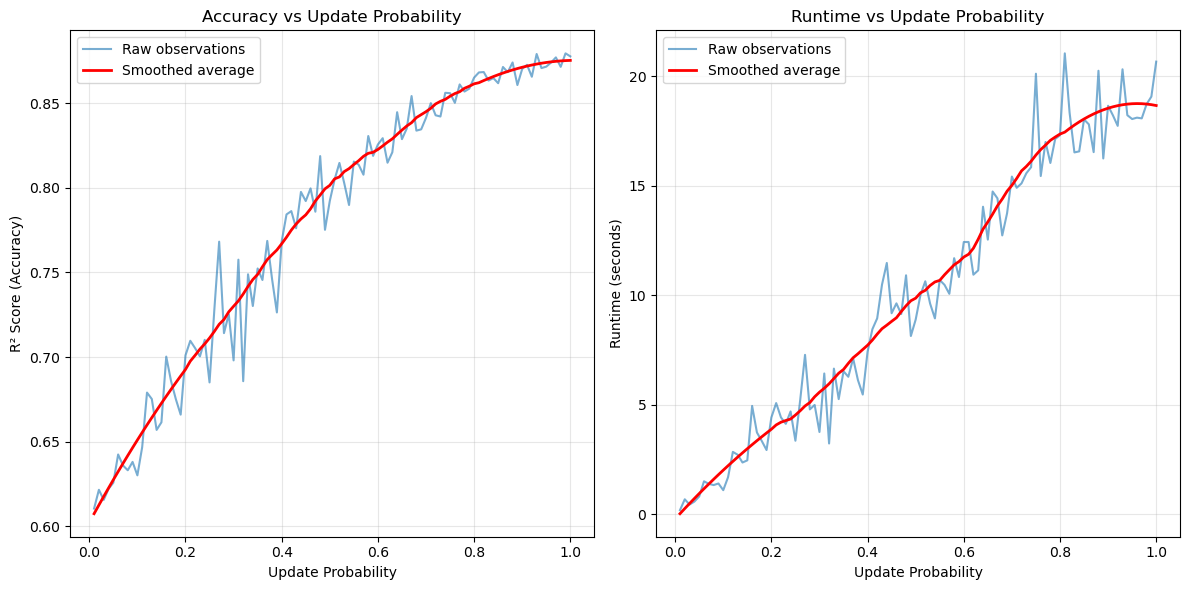

In [18]:
# Apply Savitzky-Golay smoothing to accuracy and runtime values
smoothed_accuracy = savgol_filter(accuracy_values, window_length=40, polyorder=2)
smoothed_runtime = savgol_filter(runtime_values, window_length=40, polyorder=2)

# Plot the results
plt.figure(figsize=(12, 6))

# # Plot MAE vs probability
# plt.subplot(1, 3, 1)
# plt.plot(probabilities, mae_values, marker='o')
# plt.xlabel("Update Probability")
# plt.ylabel("Mean Absolute Error (MAE)")
# plt.title("MAE vs Update Probability")
# plt.grid(alpha=0.3)

# Plot Accuracy vs Probability
plt.subplot(1, 2, 1)
plt.plot(probabilities, accuracy_values, label='Raw observations', alpha=0.6)
plt.plot(probabilities, smoothed_accuracy, color='red', label='Smoothed average', linewidth=2)
plt.xlabel("Update Probability")
plt.ylabel("R² Score (Accuracy)")
plt.title("Accuracy vs Update Probability")
plt.grid(alpha=0.3)
plt.legend()

# Plot Runtime vs Probability
plt.subplot(1, 2, 2)
plt.plot(probabilities, runtime_values, label='Raw observations', alpha=0.6)
plt.plot(probabilities, smoothed_runtime, color='red', label='Smoothed average', linewidth=2)
plt.xlabel("Update Probability")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime vs Update Probability")
plt.grid(alpha=0.3)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [19]:
# Calculate first-order difference (derivative approximation)
accuracy_gain = np.diff(smoothed_accuracy) / np.diff(probabilities)

# Find the index where the maximum gain occurs
max_gain_index = np.argmax(accuracy_gain)

# Get the probability corresponding to the maximum accuracy gain
best_probability = probabilities[max_gain_index]

# Print the result
print(f"The highest accuracy gain occurs at update probability: {best_probability:.2f}")
print(f"Maximum accuracy gain value: {accuracy_gain[max_gain_index]:.4f}")


The highest accuracy gain occurs at update probability: 0.01
Maximum accuracy gain value: 0.5113


In [20]:
# Define accuracy threshold
accuracy_threshold = 0.75

# Find indices where accuracy is above the threshold
valid_indices = np.where(smoothed_accuracy >= accuracy_threshold)[0]

# Filter the probabilities and smoothed accuracy based on the threshold
filtered_probabilities = probabilities[valid_indices]
filtered_accuracy = smoothed_accuracy[valid_indices]

# Compute the first-order difference (derivative approximation)
accuracy_gain_filtered = np.diff(filtered_accuracy) / np.diff(filtered_probabilities)

# Find the index where the maximum gain occurs after filtering
max_gain_index_filtered = np.argmax(accuracy_gain_filtered)

# Get the corresponding probability where the maximum gain happens
best_probability_filtered = filtered_probabilities[max_gain_index_filtered]

# Print the results
print(f"The highest accuracy gain (above 0.75) occurs at update probability: {best_probability_filtered:.2f}")
print(f"Maximum accuracy gain value: {accuracy_gain_filtered[max_gain_index_filtered]:.4f}")


The highest accuracy gain (above 0.75) occurs at update probability: 0.46
Maximum accuracy gain value: 0.4629
